#Predicting Political party affiliation using Tweets

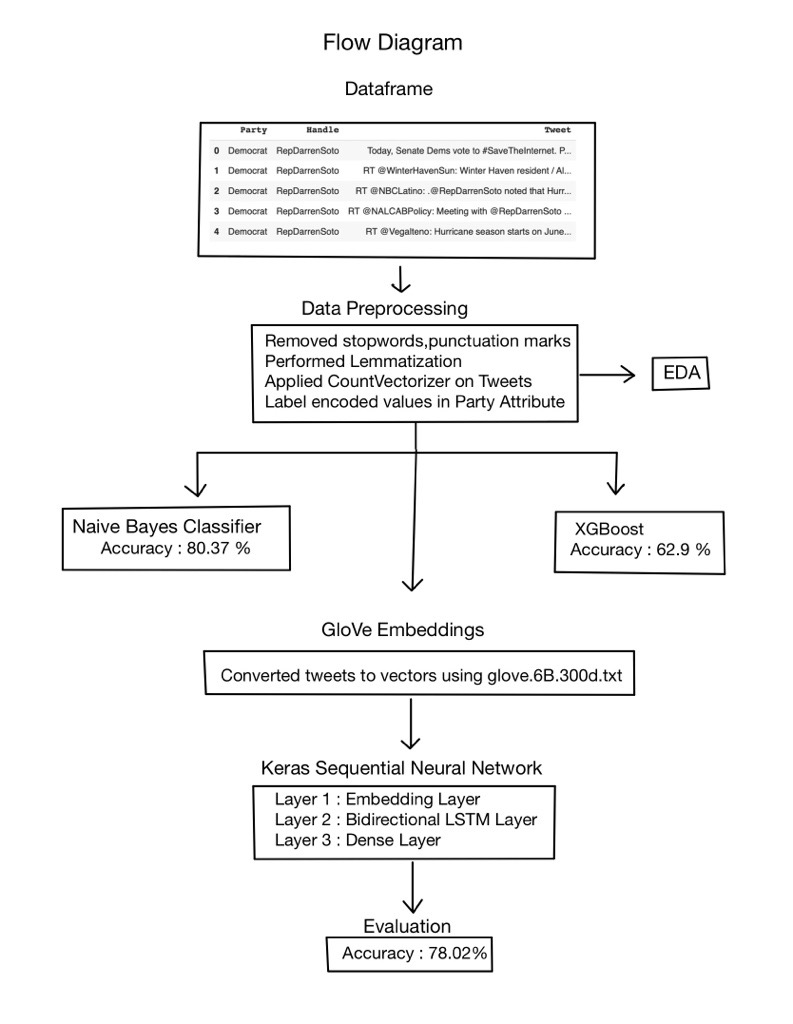

#**Data Preprocessing and EDA**

In [ ]:
#import all the required libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
from wordcloud import WordCloud


## Import Data

In [ ]:
dt=pd.read_csv("https://raw.githubusercontent.com/nehayadav7295/DataSets/main/ExtractedTweets.csv")

In [ ]:
dt.shape

(86460, 3)

In [ ]:
dt.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


In [ ]:
dt["Party"].unique()

array(['Democrat', 'Republican'], dtype=object)

## Exploratory Data Analysis

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


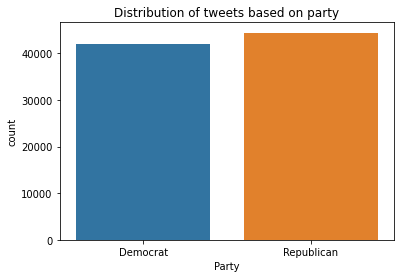

In [ ]:
sns.countplot(dt["Party"])
plt.title("Distribution of tweets based on party")
plt.show()

### The data is balanced for both classes hence we are not removing any data to balance classes

In [ ]:
dt["Tweet Length"] = dt["Tweet"].apply(len)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


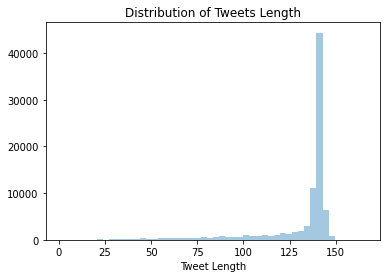

In [ ]:
sns.distplot(dt["Tweet Length"], kde=False)
plt.title("Distribution of Tweets Length")
plt.show()

* Most of the tweets have word count of 130-145
* No tweet has zero word count hence no null values 




In [ ]:
df=dt.loc[:, ['Party', 'Tweet']]

In [ ]:
df.head()

,Party,Tweet
0,Democrat,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RT @Vegalteno: Hurricane season starts on June...


In [ ]:
#downloading some required packages and corpora in the (nltk) library
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stopwords = stopwords.words('english')

#adding some unnecessary words to stopwords list
stopwords.append("rt")
stopwords.append("u")
stopwords.append("amp")
stopwords.append("w")
stopwords.append("th")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
democrat=df[df.Party=="Democrat"]
republican=df[df.Party=="Republican"]

In [ ]:
#text pre-processing on the tweets in the "democrat"
democrat_list=[]
for r in democrat.Tweet:
    r=re.sub(r'http\S+', '', r)
    r=re.sub("[^a-zA-Z]", " ", r)
    r=r.lower()
    r=nltk.word_tokenize(r)
    r=[word for word in r if not word in set(stopwords)]
    lemma=nlp.WordNetLemmatizer()
    r=[lemma.lemmatize(word) for word in r]
    r=" ".join(r)
    democrat_list.append(r)

In [ ]:
#text pre-processing on the tweets in the "republican"
republican_list=[]
for r in republican.Tweet:
    r=re.sub(r'http\S+', '', r)
    r=re.sub("[^a-zA-Z]", " ", r)
    r=r.lower()
    r=nltk.word_tokenize(r)
    r=[word for word in r if not word in set(stopwords)]
    lemma=nlp.WordNetLemmatizer()
    r=[lemma.lemmatize(word) for word in r]
    r=" ".join(r)
    republican_list.append(r)

In [ ]:
democrat['processed_tweet'] = democrat_list
republican['processed_tweet'] = republican_list

<ipython-input-15-90d4a0d9b8b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  democrat['processed_tweet'] = democrat_list
<ipython-input-15-90d4a0d9b8b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  republican['processed_tweet'] = republican_list


In [ ]:
tweets = pd.concat([democrat, republican], axis=0)

In [ ]:
tweets.head()

,Party,Tweet,processed_tweet
0,Democrat,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote savetheinternet proud s...
1,Democrat,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter resident alta vista teac...
2,Democrat,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,nbclatino repdarrensoto noted hurricane maria ...
3,Democrat,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,nalcabpolicy meeting repdarrensoto thanks taki...
4,Democrat,RT @Vegalteno: Hurricane season starts on June...,vegalteno hurricane season start june st puert...


In [ ]:
from textblob import TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [ ]:
tweets['sentiment'] = tweets['processed_tweet'].apply(get_sentiment)

In [ ]:
tweets['sentiment_label'] = tweets['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative')


In [ ]:
grouped = tweets.groupby('Party')['sentiment'].mean()

In [ ]:
print(grouped)

Party
Democrat      0.121610
Republican    0.148791
Name: sentiment, dtype: float64


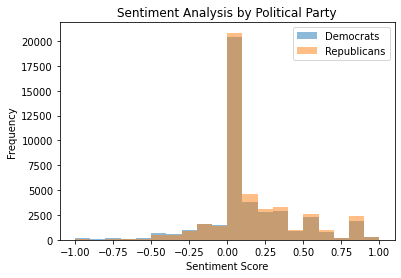

In [ ]:
dem_sentiment = tweets[tweets['Party'] == 'Democrat']['sentiment']
plt.hist(dem_sentiment, bins=20, alpha=0.5, label='Democrats')

# Create a histogram of sentiment scores for Republicans
rep_sentiment = tweets[tweets['Party'] == 'Republican']['sentiment']
plt.hist(rep_sentiment, bins=20, alpha=0.5, label='Republicans')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis by Political Party')
plt.legend()
plt.show()

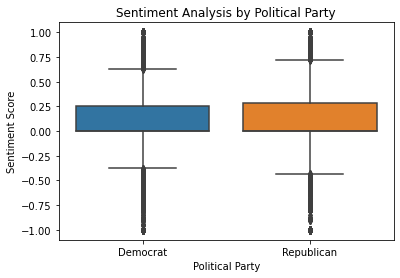

In [ ]:
import seaborn as sns

# Create a box plot of sentiment scores by political party
sns.boxplot(x='Party', y='sentiment', data=tweets)

# Add labels and title
plt.xlabel('Political Party')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis by Political Party')

# Show the plot
plt.show()

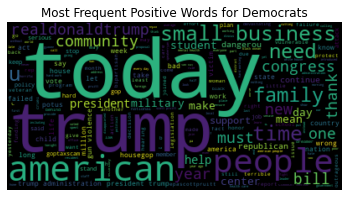

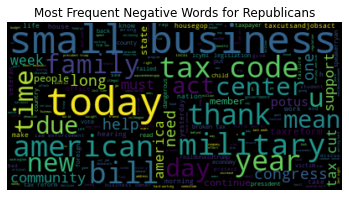

In [ ]:
from wordcloud import WordCloud


dem_pos = tweets[(tweets['Party'] == 'Democrat') & (tweets['sentiment'] < 0)]['processed_tweet']
dem_pos_wordcloud = WordCloud().generate(' '.join(dem_pos))
plt.imshow(dem_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Positive Words for Democrats')

# Show the plot
plt.show()

# Create a word cloud of the most frequent negative words for Republicans
rep_neg = tweets[(tweets['Party'] == 'Republican') & (tweets['sentiment'] < 0)]['processed_tweet']
rep_neg_wordcloud = WordCloud().generate(' '.join(rep_neg))
plt.imshow(rep_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Negative Words for Republicans')

# Show the plot
plt.show()






In [ ]:
democrat_list[0:5]

['today senate dems vote savetheinternet proud support similar netneutrality legislation house',
 'winterhavensun winter resident alta vista teacher one several recognized repdarrensoto national teacher apprecia',
 'nbclatino repdarrensoto noted hurricane maria left approximately billion damage congress allocated',
 'nalcabpolicy meeting repdarrensoto thanks taking time meet latinoleader ed marucci guzman nalcabpolicy',
 'vegalteno hurricane season start june st puerto rico readiness well pwr puertorico repdarrensoto espaillatny']

In [ ]:
republican_list[0:5]

['wastefulwednesday today introduced bill would eliminate global climate change initiative gc',
 'today honored heroic men woman law enforcement lost life line duty nati',
 'congressmanraja last week repralphnorman hosted briefing economic benefit solar energy production',
 'tegacaypd chief parker thankful receive recognition repralphnorman delivered mayor davidloneal national police',
 'visited sc highway patrol bring cupcake thank service honor']

In [ ]:
democrat_tweets=str(democrat_list).split()
republican_tweets=str(republican_list).split()
democrat_tweets=[word.replace("'","") for word in democrat_tweets ]
democrat_tweets=[word.replace("[", "") for word in democrat_tweets ]
democrat_tweets=[word.replace("]","") for word in democrat_tweets ]
democrat_tweets=[word.replace(",", "") for word in democrat_tweets ]

republican_tweets=[word.replace("'","") for word in republican_tweets ]
republican_tweets=[word.replace("[", "") for word in republican_tweets ]
republican_tweets=[word.replace("]","") for word in republican_tweets ]
republican_tweets=[word.replace(",", "") for word in republican_tweets ]

In [ ]:
print("Democrat tweets word length:",len(democrat_list))
print("Republican tweets word length:",len(republican_list))

Democrat tweets word length: 42068
Republican tweets word length: 44392


In [ ]:
from nltk.probability import FreqDist
fdist_democrat = FreqDist(democrat_tweets)
fdist_republican=FreqDist(republican_tweets)

In [ ]:
fdist_democrat

FreqDist({'today': 3850, 'trump': 2502, 'american': 2053, 'year': 1835, 'thank': 1777, 'family': 1694, 'great': 1676, 'student': 1660, 'day': 1571, 'congress': 1518, ...})

In [ ]:
fdist_republican

FreqDist({'today': 4883, 'tax': 2885, 'great': 2876, 'house': 2382, 'bill': 2379, 'american': 2241, 'thank': 2118, 'year': 1961, 'day': 1887, 'act': 1820, ...})

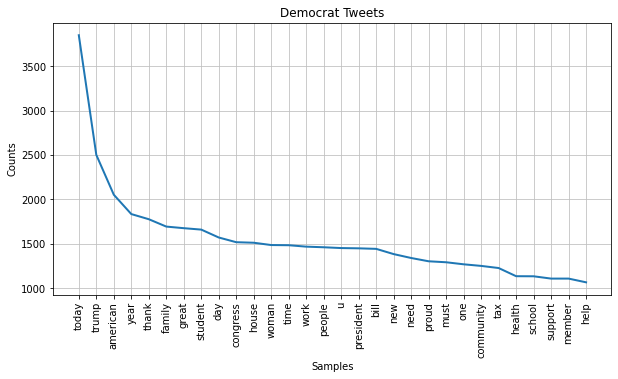

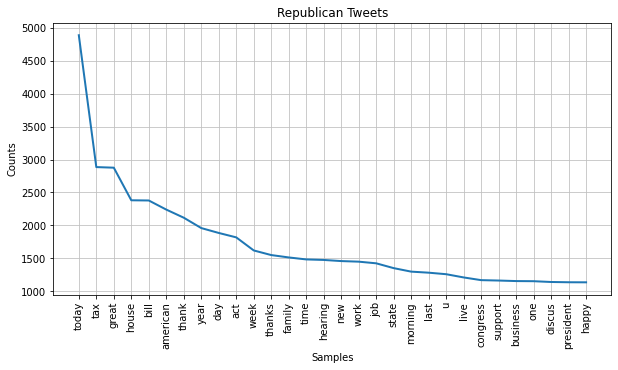

In [ ]:
plt.subplots(figsize=(10,5))
fdist_democrat.plot(30,title="Democrat Tweets")
plt.subplots(figsize=(10,5))
fdist_republican.plot(30,title="Republican Tweets")



*   The above plots shows the most frequent words for each classes 
*   We can see alot of coinciding words for both the classes



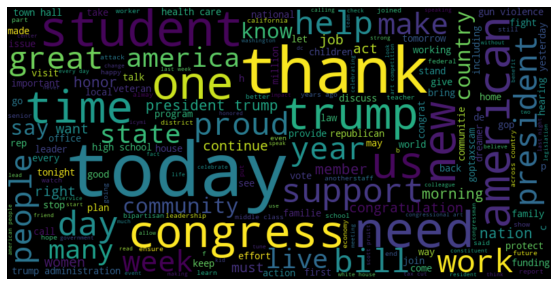

In [ ]:
# Join all the tweets into a single string
democrat_tweets = " ".join(democrat["Tweet"].str.lower().values)

# Remove mentions (@), RT, links (http), and punctuation
democrat_tweets = re.sub(r"(@\w+)|(RT)|(http\S+)|(\W)", " ", democrat_tweets)

# Remove stop words
democrat_tweets = " ".join([word for word in democrat_tweets.split() if word not in stopwords])

# Create the wordcloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(democrat_tweets)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


* Wordcloud of all the tweets and we can see that most of the most of the discussion contains the word trump, american, president and etc.
* The size of the word depends on the frequency of the word



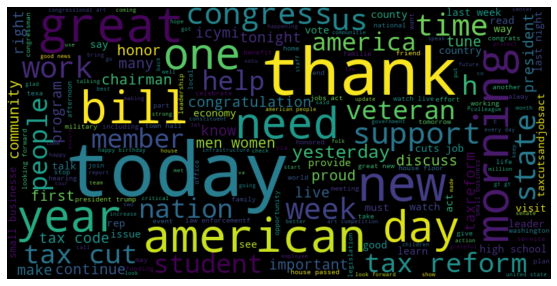

In [ ]:
# Join all the tweets into a single string
republican_tweets = " ".join(republican["Tweet"].str.lower().values)

# Remove mentions (@), RT, links (http), and punctuation
republican_tweets  = re.sub(r"(@\w+)|(RT)|(http\S+)|(\W)", " ", republican_tweets)

# Remove stop words
republican_tweets  = " ".join([word for word in republican_tweets .split() if word not in stopwords])

# Create the wordcloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(republican_tweets)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Classification Tweets using XGBoost, Naive Bayes and Bi-direction GRU and LSTM

In [ ]:
from sklearn.metrics import classification_report

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt

Accuracy: 62.90%


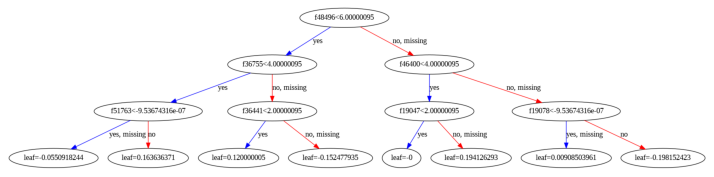

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets["processed_tweet"])
y = tweets["Party"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

# Train the XGBoost classifier
XGBoost_model = XGBClassifier()
XGBoost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = XGBoost_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
plt.rcParams["figure.figsize"] = (20,3)
plot_tree(XGBoost_model)
plt.show()

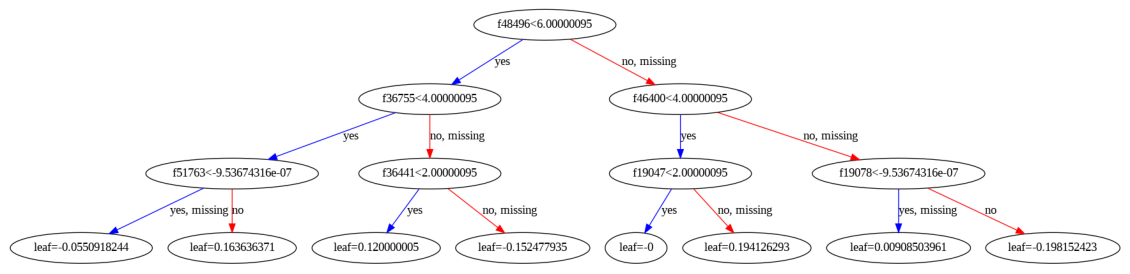

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plot_tree(XGBoost_model)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Democrat       0.78      0.33      0.46     12600
  Republican       0.59      0.91      0.72     13338

    accuracy                           0.63     25938
   macro avg       0.69      0.62      0.59     25938
weighted avg       0.68      0.63      0.59     25938



#Naive Bayes classifier

In [ ]:
# Train the Naive Bayes classifier
NBC_model = MultinomialNB()
NBC_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = NBC_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 80.37%


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Democrat       0.81      0.77      0.79     12600
  Republican       0.79      0.83      0.81     13338

    accuracy                           0.80     25938
   macro avg       0.80      0.80      0.80     25938
weighted avg       0.80      0.80      0.80     25938

